# LIBRERIAS NECESARIAS. CONFIGURACION.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

# Varios
# ==============================================================================
import multiprocessing
import os
import sys


In [2]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

In [3]:
DATA_FOLDER = '../data'
OUTPUT_FOLDER = '../output'
EDA_DATAFILE = 'life_expectance_EDA.csv'
MODELS_FOLDER = '../models'
UTILS_FOLDER = '../utils'

NUM_CORES = multiprocessing.cpu_count() - 1

sys.path.append(os.path.abspath(UTILS_FOLDER))


In [4]:
%load_ext autoreload
%autoreload 2

# CARGA DATOS

In [5]:
df_le = pd.read_csv(os.path.join(DATA_FOLDER,EDA_DATAFILE), dtype={'Country': 'category', 'Status': 'category'},
                    index_col=['Country', 'Year'])

df_le.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, ('Afghanistan', 2015) to ('Zimbabwe', 2000)
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Status                2916 non-null   category
 1   Income_index          2637 non-null   float64 
 2   pct_total_exp         2702 non-null   float64 
 3   GDP                   2481 non-null   float64 
 4   Hepatitis_B           2375 non-null   float64 
 5   Polio                 2908 non-null   float64 
 6   Diphtheria            2908 non-null   float64 
 7   Measles               2392 non-null   float64 
 8   HIV_AIDS              2916 non-null   float64 
 9   BMI                   2896 non-null   float64 
 10  Alcohol               2735 non-null   float64 
 11  thinness__1_19_years  2896 non-null   float64 
 12  infant_deaths         2903 non-null   float64 
 13  Adult_Mortality       2916 non-null   float64 
 14  Life_expectancy       

In [6]:
df_le.sort_index(level=['Country', 'Year'], inplace=True)

df_le

Status  Income_index  pct_total_exp         GDP  \
Country     Year                                                        
Afghanistan 2000  Developing         0.338           8.20  114.560000   
            2001  Developing         0.340           7.80  117.496980   
            2002  Developing         0.341           7.76  187.845950   
            2003  Developing         0.373           8.82  198.728544   
            2004  Developing         0.381           8.79  219.141353   
...                      ...           ...            ...         ...   
Zimbabwe    2011  Developing         0.452           6.31  839.927936   
            2012  Developing         0.464           6.69  955.648466   
            2013  Developing         0.488           6.88  111.227396   
            2014  Developing         0.498           6.44  127.474620   
            2015  Developing         0.507            NaN  118.693830   

                  Hepatitis_B  Polio  Diphtheria  Measles  HIV_AIDS   BMI  \
Country     Year                                                            
Afghanistan 2000         62.0   24.0        24.0      NaN       0.1  12.2   
            2001         63.0   35.0        33.0      NaN       0.1  12.6   
            2002         64.0   36.0        36.0      NaN       0.1  13.0   
            2003         65.0   41.0        41.0    798.0       0.1  13.4   
            2004         67.0    5.0         5.0    466.0       0.1  13.8   
...                       ...    ...         ...      ...       ...   ...   
Zimbabwe    2011         94.0   93.0        93.0      0.0      13.3  29.9   
            2012         97.0   95.0        95.0      0.0       8.8   3.3   
            2013         95.0   95.0        95.0      0.0       6.8   3.8   
            2014         91.0   92.0        91.0      0.0       6.3  31.3   
            2015         87.0   88.0        87.0      0.0       6.2  31.8   

                  Alcohol  thinness__1_19_years  infant_deaths  \
Country     Year                                                 
Afghanistan 2000     0.01                   2.3           88.0   
            2001     0.01                   2.1           88.0   
            2002     0.01                  19.9           88.0   
            2003     0.01                  19.7           87.0   
            2004     0.02                  19.5           87.0   
...                   ...                   ...            ...   
Zimbabwe    2011     6.00                   6.8           28.0   
            2012     6.09                   6.5           26.0   
            2013     6.39                   6.2           25.0   
            2014     6.50                   5.9           23.0   
            2015      NaN                   5.6           22.0   

                  Adult_Mortality  Life_expectancy  
Country     Year                                    
Afghanistan 2000            321.0             54.8  
            2001            316.0             55.3  
            2002              3.0             56.2  
            2003            295.0             56.7  
            2004            293.0             57.0  
...                           ...              ...  
Zimbabwe    2011            464.0             54.9  
            2012            429.0             56.6  
            2013            399.0             58.0  
            2014            371.0             59.2  
            2015            336.0             67.0  

[2916 rows x 15 columns]

## Repasamos columnas con nulos.

In [7]:
df_le.isna().sum().sort_values(ascending=False)

Hepatitis_B             541
Measles                 524
GDP                     435
Income_index            279
pct_total_exp           214
Alcohol                 181
BMI                      20
thinness__1_19_years     20
infant_deaths            13
Polio                     8
Diphtheria                8
Status                    0
HIV_AIDS                  0
Adult_Mortality           0
Life_expectancy           0
dtype: int64

**'Dividimos' columnas por tipo para mejor tratamiento posterior:**

In [8]:
TARGET = 'Life_expectancy'

# aparte de 'make_column_selector', necesario para renombrar columnas salida preprx
categ_col = df_le.select_dtypes(include='category').columns.to_list()
num_col = df_le.select_dtypes(exclude='category').drop(columns=TARGET).columns.to_list()


col_NA = [column for column in df_le.columns if df_le[column].isna().sum()>0]

# todas las numéricas lo necesitan
col_Pwr_Transf = num_col.copy()


# DIVISION TRAIN TEST. DEFINICIÓN Y APLICACIÓN PREPROCESADO

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_le.drop(columns=TARGET), df_le[TARGET],test_size=0.2,
                                                    random_state=12, stratify=df_le.Status)

In [10]:
print('TRAIN: ', X_train.shape, y_train.shape)

print('TEST: ', X_test.shape, y_test.shape)

TRAIN:  (2332, 14) (2332,)
TEST:  (584, 14) (584,)


## PREPROCESADO (acciones propuestas y no realizadas notebook EDA)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.preprocessing import PowerTransformer, OneHotEncoder


In [12]:
num_transformer = Pipeline(steps=
                           [('imputer',
                             IterativeImputer(random_state=22)),
                            ('pow_transf',
                             PowerTransformer(method='yeo-johnson',standardize=True))])

categ_transformer = OneHotEncoder(drop='if_binary', dtype=np.int8)

preprx = ColumnTransformer(transformers=[('numeric',num_transformer,num_col),
                                        ('category',categ_transformer,categ_col)],
                          remainder='passthrough',
                          n_jobs=NUM_CORES)


# estimator=ExtraTreesRegressor(max_depth=5,random_state=22,n_jobs=multiprocessing.cpu_count()-1)

In [13]:
from sklearn import set_config
set_config(display='diagram')

preprx

ColumnTransformer(n_jobs=11, remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(random_state=22)),
                                                 ('pow_transf',
                                                  PowerTransformer())]),
                                 ['Income_index', 'pct_total_exp', 'GDP',
                                  'Hepatitis_B', 'Polio', 'Diphtheria',
                                  'Measles', 'HIV_AIDS', 'BMI', 'Alcohol',
                                  'thinness__1_19_years', 'infant_deaths',
                                  'Adult_Mortality']),
                                ('category',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'numpy.int8'>),
                                 ['Status'])])

In [14]:
set_config(display='text')

In [15]:
X_train_preprx = preprx.fit_transform(X_train)
X_test_preprx = preprx.transform(X_test)

In [16]:
print(X_train_preprx.shape)
X_train_preprx

(2332, 14)


array([[ 0.54888279,  0.37908489, -0.11406849, ..., -0.597534  ,
         0.22142784,  0.        ],
       [ 1.5345272 ,  0.84637386, -0.28552018, ..., -1.22385564,
        -0.55185231,  0.        ],
       [ 0.19784511,  0.11752495,  0.05145037, ..., -0.27521859,
         0.8649538 ,  1.        ],
       ...,
       [ 1.3721944 ,  0.41902828, -0.35662681, ..., -1.22385564,
        -0.13539152,  1.        ],
       [-1.40212272, -0.06387271, -0.47035482, ...,  0.08998998,
         1.01566785,  1.        ],
       [-0.62880215,  0.41861003, -0.34737028, ...,  0.77650352,
        -1.49346161,  1.        ]])

In [17]:
print(X_test_preprx.shape)
X_test_preprx

(584, 14)


array([[ 4.80033067e-01,  1.05098059e+00, -5.04633104e-01, ...,
        -1.22385564e+00, -6.39133602e-04,  1.00000000e+00],
       [-1.17000521e+00,  8.24106493e-01, -5.36135084e-01, ...,
        -1.22385564e+00, -1.42113909e+00,  1.00000000e+00],
       [ 4.32220243e-01,  1.17605059e+00, -2.85977905e-01, ...,
         8.99899832e-02, -1.16877041e-01,  1.00000000e+00],
       ...,
       [-1.02810242e+00, -1.04395849e+00, -3.05121592e-01, ...,
         2.00547384e+00,  1.49213606e+00,  1.00000000e+00],
       [-1.42662887e+00, -5.59980016e-01, -4.97774656e-01, ...,
         1.07725744e+00, -7.00016176e-01,  1.00000000e+00],
       [ 6.73986877e-02,  2.66841476e-01, -1.46712062e-01, ...,
        -2.75218592e-01,  3.50300964e-01,  1.00000000e+00]])

### Acceso a los componentes del preprx

In [18]:
num_transformer.named_steps

{'imputer': IterativeImputer(random_state=22),
 'pow_transf': PowerTransformer()}

In [19]:
num_transformer.named_steps.imputer.get_params()

{'add_indicator': False,
 'estimator': None,
 'imputation_order': 'ascending',
 'initial_strategy': 'mean',
 'max_iter': 10,
 'max_value': inf,
 'min_value': -inf,
 'missing_values': nan,
 'n_nearest_features': None,
 'random_state': 22,
 'sample_posterior': False,
 'skip_complete': False,
 'tol': 0.001,
 'verbose': 0}

In [20]:
num_transformer.named_steps.imputer.get_params()['initial_strategy']


'mean'

In [21]:
preprx.named_transformers_

{'numeric': Pipeline(steps=[('imputer', IterativeImputer(random_state=22)),
                 ('pow_transf', PowerTransformer())]),
 'category': OneHotEncoder(drop='if_binary', dtype=<class 'numpy.int8'>)}

In [22]:
preprx.named_transformers_.category.get_feature_names_out()

array(['Status_Developing'], dtype=object)

In [23]:
preprx.named_transformers_.category.get_params()

{'categories': 'auto',
 'drop': 'if_binary',
 'dtype': numpy.int8,
 'handle_unknown': 'error',
 'sparse': True}

**Volvemos al preprocesado**

## DATAFRAMES con el resultado del preprocesado.

In [24]:
from sklearn import set_config
set_config(display='diagram')

preprx

ColumnTransformer(n_jobs=11, remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(random_state=22)),
                                                 ('pow_transf',
                                                  PowerTransformer())]),
                                 ['Income_index', 'pct_total_exp', 'GDP',
                                  'Hepatitis_B', 'Polio', 'Diphtheria',
                                  'Measles', 'HIV_AIDS', 'BMI', 'Alcohol',
                                  'thinness__1_19_years', 'infant_deaths',
                                  'Adult_Mortality']),
                                ('category',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'numpy.int8'>),
                                 ['Status'])])

In [25]:
set_config(display='text')

preprx

ColumnTransformer(n_jobs=11, remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(random_state=22)),
                                                 ('pow_transf',
                                                  PowerTransformer())]),
                                 ['Income_index', 'pct_total_exp', 'GDP',
                                  'Hepatitis_B', 'Polio', 'Diphtheria',
                                  'Measles', 'HIV_AIDS', 'BMI', 'Alcohol',
                                  'thinness__1_19_years', 'infant_deaths',
                                  'Adult_Mortality']),
                                ('category',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'numpy.int8'>),
                                 ['Status'])])

In [26]:
# las transformaciones (preprx) pueden alteran orden columnas (p. ej. OHE)

encode_categ_labels = preprx.named_transformers_.category.get_feature_names_out(categ_col)
labels_col = np.concatenate([num_col,encode_categ_labels])

labels_col

array(['Income_index', 'pct_total_exp', 'GDP', 'Hepatitis_B', 'Polio',
       'Diphtheria', 'Measles', 'HIV_AIDS', 'BMI', 'Alcohol',
       'thinness__1_19_years', 'infant_deaths', 'Adult_Mortality',
       'Status_Developing'], dtype=object)

In [27]:
df_train_preprx = pd.DataFrame(data=X_train_preprx, columns=labels_col)

df_train_preprx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income_index          2332 non-null   float64
 1   pct_total_exp         2332 non-null   float64
 2   GDP                   2332 non-null   float64
 3   Hepatitis_B           2332 non-null   float64
 4   Polio                 2332 non-null   float64
 5   Diphtheria            2332 non-null   float64
 6   Measles               2332 non-null   float64
 7   HIV_AIDS              2332 non-null   float64
 8   BMI                   2332 non-null   float64
 9   Alcohol               2332 non-null   float64
 10  thinness__1_19_years  2332 non-null   float64
 11  infant_deaths         2332 non-null   float64
 12  Adult_Mortality       2332 non-null   float64
 13  Status_Developing     2332 non-null   float64
dtypes: float64(14)
memory usage: 255.2 KB


In [28]:
df_train_preprx.head()

,Income_index,pct_total_exp,GDP,Hepatitis_B,Polio,Diphtheria,Measles,HIV_AIDS,BMI,Alcohol,thinness__1_19_years,infant_deaths,Adult_Mortality,Status_Developing
0,0.548883,0.379085,-0.114068,0.823015,0.695485,0.615609,-0.850505,-0.698061,-1.649232,1.292026,-0.470483,-0.597534,0.221428,0.0
1,1.534527,0.846374,-0.285520,0.255915,-0.033084,0.125985,0.354007,-0.698061,1.145805,1.113673,-1.852645,-1.223856,-0.551852,0.0
2,0.197845,0.117525,0.051450,0.748187,0.695485,0.615609,-1.164961,1.598769,0.030592,0.419278,0.707271,-0.275219,0.864954,1.0
3,1.652300,1.983912,1.955428,-2.127174,0.437924,0.445874,0.457469,-0.698061,1.296715,1.183057,-1.852645,-1.223856,-0.649045,0.0
4,-0.308962,0.685233,-0.282467,0.601937,0.437924,0.445874,-1.164961,0.921612,-1.735992,0.818740,0.552374,-0.597534,0.627700,1.0


In [29]:
df_train_preprx.columns

Index(['Income_index', 'pct_total_exp', 'GDP', 'Hepatitis_B', 'Polio',
       'Diphtheria', 'Measles', 'HIV_AIDS', 'BMI', 'Alcohol',
       'thinness__1_19_years', 'infant_deaths', 'Adult_Mortality',
       'Status_Developing'],
      dtype='object')

In [30]:
df_train_preprx.drop(columns='Status_Developing').describe()

,Income_index,pct_total_exp,GDP,Hepatitis_B,Polio,Diphtheria,Measles,HIV_AIDS,BMI,Alcohol,thinness__1_19_years,infant_deaths,Adult_Mortality
count,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03,2.332000e+03
mean,4.016703e-16,-1.738651e-16,3.206412e-17,1.108586e-16,1.902959e-16,2.509190e-16,-3.513485e-17,3.234024e-16,2.756514e-17,-3.299486e-16,-2.217113e-16,-2.875535e-17,2.647015e-17
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-2.142229e+00,-3.023656e+00,-5.713862e+00,-2.137439e+00,-2.301934e+00,-2.294181e+00,-1.164961e+00,-6.980614e-01,-1.967790e+00,-3.653693e+00,-2.123135e+00,-1.223856e+00,-2.328975e+00
25%,-8.943464e-01,-6.122812e-01,-4.864514e-01,-6.205305e-01,-5.896765e-01,-5.651126e-01,-1.164961e+00,-6.980614e-01,-9.202777e-01,-8.776935e-01,-7.779852e-01,-1.223856e+00,-6.241792e-01
50%,8.680524e-02,2.052925e-02,-3.027472e-01,3.261267e-01,4.379240e-01,4.458735e-01,8.271702e-02,-6.980614e-01,2.778406e-01,9.328772e-02,-4.392446e-02,-6.423567e-02,6.766843e-02
75%,7.664203e-01,6.319640e-01,1.375712e-01,8.230149e-01,7.847073e-01,7.920317e-01,9.518799e-01,8.031990e-01,8.976870e-01,8.582660e-01,8.447315e-01,9.396221e-01,6.731137e-01
max,2.023014e+00,3.837533e+00,6.965331e+00,1.054376e+00,9.682936e-01,9.752598e-01,1.939757e+00,1.924178e+00,1.873002e+00,2.141769e+00,2.411944e+00,2.143920e+00,2.849686e+00


Se puede ver el escalado final en las numéricas (en este caso por un parámetro de PowerTransformer)

In [31]:
df_train_preprx.Status_Developing.value_counts()

1.0    1923
0.0     409
Name: Status_Developing, dtype: int64

In [32]:
df_test_preprx = pd.DataFrame(data=X_test_preprx, columns=labels_col)

df_test_preprx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income_index          584 non-null    float64
 1   pct_total_exp         584 non-null    float64
 2   GDP                   584 non-null    float64
 3   Hepatitis_B           584 non-null    float64
 4   Polio                 584 non-null    float64
 5   Diphtheria            584 non-null    float64
 6   Measles               584 non-null    float64
 7   HIV_AIDS              584 non-null    float64
 8   BMI                   584 non-null    float64
 9   Alcohol               584 non-null    float64
 10  thinness__1_19_years  584 non-null    float64
 11  infant_deaths         584 non-null    float64
 12  Adult_Mortality       584 non-null    float64
 13  Status_Developing     584 non-null    float64
dtypes: float64(14)
memory usage: 64.0 KB


In [33]:
df_test_preprx.drop(columns='Status_Developing').describe()

,Income_index,pct_total_exp,GDP,Hepatitis_B,Polio,Diphtheria,Measles,HIV_AIDS,BMI,Alcohol,thinness__1_19_years,infant_deaths,Adult_Mortality
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.005471,-0.019598,0.058726,-0.064816,-0.048701,-0.046565,0.026849,0.018532,0.008869,0.036162,0.028046,-0.016108,0.056691
std,1.008417,1.025581,1.094174,1.003979,1.015836,1.019267,1.005701,1.013339,0.993145,1.022099,1.010814,1.023824,1.021562
min,-2.081440,-2.449746,-4.698649,-2.137788,-2.301934,-2.293994,-1.164961,-0.698061,-1.996493,-1.505357,-2.123135,-1.223856,-2.328975
25%,-0.920219,-0.629826,-0.489835,-0.703295,-0.753305,-0.685679,-1.164961,-0.698061,-0.914944,-0.878917,-0.777985,-1.223856,-0.599702
50%,0.116022,0.014177,-0.301260,0.255915,0.437924,0.363476,0.157983,-0.698061,0.294662,0.118848,0.020582,-0.064236,0.100987
75%,0.730912,0.673852,0.205126,0.823015,0.784707,0.792032,0.976830,0.921612,0.882587,0.868869,0.876793,0.955462,0.698697
max,2.047695,3.731255,6.667203,1.054376,0.968294,0.975260,1.903577,1.923572,1.788303,2.015509,2.395465,2.125157,2.770716


Este puede diferir del escalado, recordar que se entrenó solo con el train, al test se le aplicó la transformación (data leakage)

In [34]:
df_test_preprx.Status_Developing.value_counts()

1.0    481
0.0    103
Name: Status_Developing, dtype: int64

### Guardamos preprx

In [35]:
preprx_file = 'preprx.pkl'

joblib.dump(preprx,os.path.join(MODELS_FOLDER,preprx_file))


['../models\\preprx.pkl']

# MODELADO

## PRUEBA CON MODELO BASE: regresion lineal sin ajustar

In [37]:
from sklearn.linear_model import LinearRegression

linreg_base = LinearRegression(n_jobs= NUM_CORES)


In [38]:
linreg_base.fit(X_train_preprx,y_train)

print(f'TRAIN: {linreg_base.score(X_train_preprx,y_train)}', f'TEST: {linreg_base.score(X_test_preprx,y_test)}',sep='\n')

TRAIN: 0.8562480082054379
TEST: 0.8616041580399186


In [39]:
baseline_metrics = cross_val_score(linreg_base,X_train_preprx,y_train,scoring='neg_root_mean_squared_error')

print(f'mean: {np.abs(baseline_metrics.mean())}, std: {baseline_metrics.std()}')

mean: 3.604777258475054, std: 0.09472428855241095


In [40]:
y_pred = linreg_base.predict(X_test_preprx)

mean_squared_error(y_test,y_pred,squared=False)

3.5836134448835884

## MODELADO

Vamos a probar con 3 modelos: Lasso, GBRegressor y XGBoost.

In [41]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

### - LASSO

In [42]:
lasso = Lasso()

param_grid = {'alpha': np.logspace(-3,4,8)}

grid_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                         n_jobs=NUM_CORES, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=22),
                         verbose=0, return_train_score=True)

In [43]:
_ = grid_lasso.fit(X_train_preprx,y_train)

In [44]:
resultados_lasso = pd.DataFrame(grid_lasso.cv_results_)
resultados_lasso.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,0.01,-3.604626,0.093627,-3.577490,0.023502
0,0.001,-3.606058,0.093362,-3.577041,0.023536
2,0.1,-3.614020,0.098234,-3.593243,0.023228
3,1.0,-3.878389,0.125895,-3.867804,0.022967
4,10.0,-9.441943,0.334722,-9.441720,0.084002
5,100.0,-9.441943,0.334722,-9.441720,0.084002
6,1000.0,-9.441943,0.334722,-9.441720,0.084002
7,10000.0,-9.441943,0.334722,-9.441720,0.084002


In [51]:
print(grid_lasso.best_params_)

grid_lasso.score(X_train_preprx,y_train)

{'alpha': 0.01}


-3.580620255852547

In [52]:
grid_lasso.score(X_test_preprx,y_test)

-3.587121125328993

#### Mejor un helper para cuando lo hagamos con los otros modelos

,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,0.01,3.604626,0.093627,3.577490,0.023502
0,0.001,3.606058,0.093362,3.577041,0.023536
2,0.1,3.614020,0.098234,3.593243,0.023228
3,1.0,3.878389,0.125895,3.867804,0.022967
4,10.0,9.441943,0.334722,9.441720,0.084002


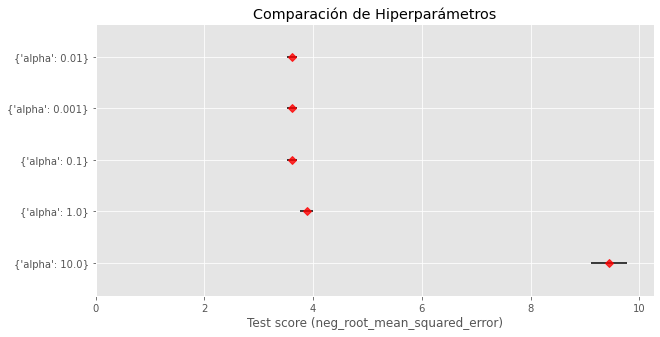

In [46]:
from cust_model_plot import resultados_GSearchCV

resultados_GSearchCV(grid_lasso.cv_results_,metric_descrip=grid_lasso.scoring)

In [47]:
grid_lasso.score(X_test_preprx,y_test)

-3.587121125328993

#### HELPER FEATURE IMPORTANCE

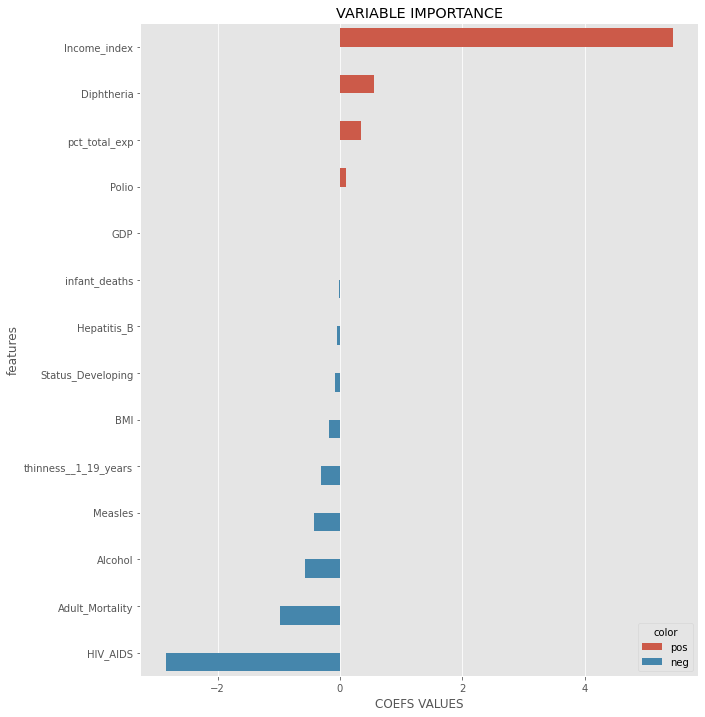

In [48]:
from cust_model_plot import plot_feature_importance

plot_feature_importance(column_names=df_train_preprx.columns, 
                        model_importance=grid_lasso.best_estimator_.coef_, 
                        model_based_type='linear')

### GRADIENT BOOST REGRESSOR

In [49]:
### GBRegressor.

gbreg = GradientBoostingRegressor(n_estimators=500,random_state=22,verbose=0,
                                  validation_fraction=0.1,n_iter_no_change=5, tol=1.e-4)



param_grid_gbr = {'learning_rate': np.logspace(-3,2,6),
                 'max_depth': [3,5,7,10],
                 'subsample': [0.5,0.7,1.0],
                 'max_features': [None,'sqrt']}

grid_gbreg = GridSearchCV(estimator=gbreg, param_grid=param_grid_gbr, scoring='neg_root_mean_squared_error',
                          n_jobs=NUM_CORES, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=22),
                          verbose=0, refit=True, return_train_score=True)



In [50]:
_ = grid_gbreg.fit(X_train_preprx,y_train)

,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
42,0.01,10,None,0.5,1.894684,0.113137,0.719100,0.055111
43,0.01,10,None,0.7,1.914009,0.121618,0.651560,0.064798
46,0.01,10,sqrt,0.7,1.931575,0.101976,0.653638,0.052229
47,0.01,10,sqrt,1.0,1.941193,0.107213,0.625807,0.053576
37,0.01,7,None,0.7,1.942505,0.112995,0.916451,0.052950


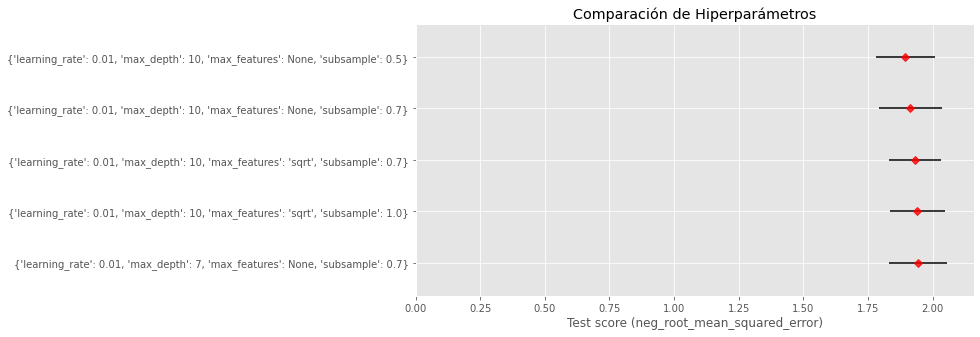

In [53]:
resultados_GSearchCV(grid_gbreg.cv_results_,metric_descrip=grid_gbreg.scoring)

In [54]:
print(grid_gbreg.best_params_)

grid_gbreg.score(X_test_preprx,y_test)

{'learning_rate': 0.01, 'max_depth': 10, 'max_features': None, 'subsample': 0.5}


-1.9103348841664454

In [55]:
grid_gbreg.best_estimator_.n_estimators_


417

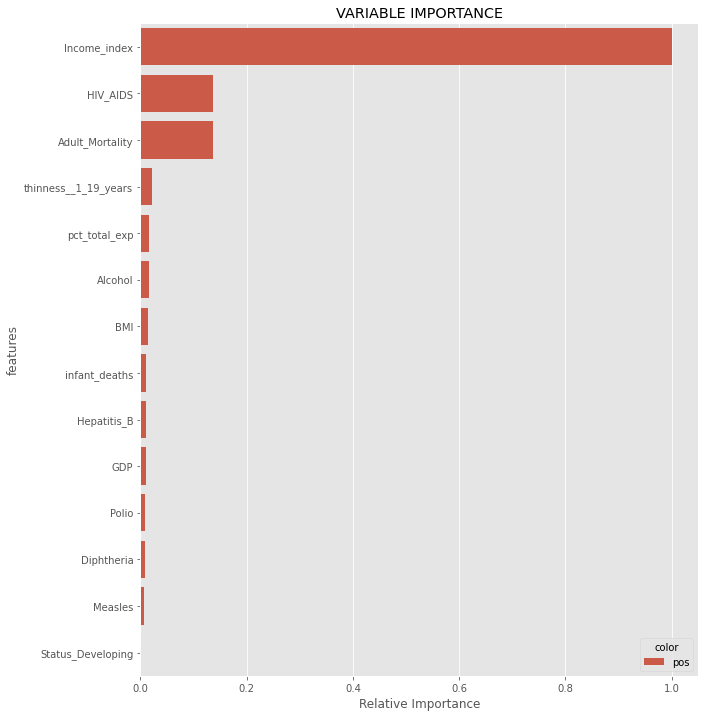

In [56]:
plot_feature_importance(column_names=df_train_preprx.columns, 
                        model_importance=grid_gbreg.best_estimator_.feature_importances_, 
                        model_based_type='tree')

### - XGBRegressor.

In [ ]:
xgbregr = XGBRegressor(n_estimators=1000, booster='gbtree', random_state=22, n_jobs=NUM_CORES, verbosity=0)



In [ ]:
# a diferencia de GBRegr de scikit, xgboost no crea de forma automatica cjto validación para el early stopping
# debemos crear una particion del TRAIN: 'train_grid' (fit de GridSearch) y 'val' que habrá que pasar junto
# a los parámetros relativos al early stopping como fit_params

# creamos partición para 'early stopping' (0.1 proporc)
np.random.seed(123)
idx_validacion = np.random.choice(X_train_preprx.shape[0], size= int(X_train_preprx.shape[0]*0.1), replace=False)

X_val = df_train_preprx.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = df_train_preprx.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()


# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : False}


# Grid Search CV
param_grid_xgbr = {'learning_rate'    : np.logspace(-4,1,num=6),
                   'max_depth'        : [1, 3, 5, 7, 10, 20],
                   'subsample'        : [0.5, 0.7, 1],
                   'colsample_bynode ': [0.3, 0.5, 1]}

grid_xgb = GridSearchCV(estimator=xgbregr, param_grid=param_grid_gbr, scoring='neg_root_mean_squared_error',
                        n_jobs=NUM_CORES, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=22),
                        verbose=0, refit=True, return_train_score=True)

_ = grid_xgb.fit(X_train_grid,y_train_grid,**fit_params)




In [ ]:
resultados_GSearchCV(grid_xgb.cv_results_,metric_descrip=grid_xgb.scoring)

In [ ]:
grid_xgb.score(df_test_preprx,y_test)

In [ ]:
grid_xgb.best_estimator_.n_estimators

In [ ]:
plot_feature_importance(column_names=df_train_preprx.columns, 
                        model_importance=grid_xgb.best_estimator_.feature_importances_, 
                        model_based_type='tree')

### Vamos a probar con otro preprocesado, sin PowerTransf ni escalado para el XGBoost:

#### Nuevo preprocesado sin Power Transform ni escalado

In [ ]:
num_transformer_xgb = IterativeImputer(random_state=22)

categ_transformer_xgb = OneHotEncoder(drop='if_binary', dtype=np.int32)

preprx_xgb = ColumnTransformer(transformers=[('numeric',num_transformer_xgb,num_col), 
                                             ('category',categ_transformer_xgb,categ_col)], 
                               remainder='passthrough')


# estimator=ExtraTreesRegressor(max_depth=5,random_state=22,n_jobs=multiprocessing.cpu_count()-1)

In [ ]:
from sklearn import set_config
set_config(display='diagram')

preprx_xgb

In [ ]:
set_config(display='text')

In [ ]:
X_train_preprx_xgb = preprx_xgb.fit_transform(X_train)
X_test_preprx_xgb = preprx_xgb.transform(X_test)

In [ ]:
# las transformaciones (preprx) alteran orden columnas (p. ej. OHE)

encode_categ_labels = preprx_xgb.named_transformers_.category.get_feature_names_out(categ_col)
labels_col = np.concatenate([num_col,encode_categ_labels])

labels_col

In [ ]:
df_train_preprx_xgb = pd.DataFrame(data=X_train_preprx_xgb, columns=labels_col)

df_train_preprx_xgb.describe()

In [ ]:
df_train_preprx_xgb.head()

In [ ]:
df_test_preprx_xgb = pd.DataFrame(data=X_test_preprx_xgb, columns=labels_col)

df_test_preprx_xgb.describe()

#### Grid Search XGB con el nuevo preprocesado

In [ ]:
# a diferencia de GBRegr de scikit, xgboost no cre de forma automatica cjto validación para el early stopping
# debemos crear una particion del TRAIN: 'train_grid' (fit de GridSearch) y 'val' que habrá que pasar junto
# a los parámetros relativos al early stopping como fit_params

# creamos partición para 'early stopping' (0.1 proporc)
np.random.seed(123)
idx_validacion = np.random.choice(X_train_preprx_xgb.shape[0], size= int(X_train_preprx_xgb.shape[0]*0.1), replace=False)

X_val = df_train_preprx_xgb.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = df_train_preprx_xgb.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()


# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : False}


# Grid Search CV
param_grid_xgbr = {'learning_rate'    : np.logspace(-4,1,num=6),
                   'max_depth'        : [1, 3, 5, 7, 10, 20],
                   'subsample'        : [0.5, 0.7, 1],
                   'colsample_bynode ': [0.3, 0.5, 1]}

grid_xgb_sin_pw_transf = GridSearchCV(estimator=xgbregr, param_grid=param_grid_gbr, scoring='neg_root_mean_squared_error', 
                         n_jobs=NUM_CORES, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=22), 
                         verbose=0, refit=True, return_train_score=True)

_ = grid_xgb_sin_pw_transf.fit(X_train_grid,y_train_grid,**fit_params)




In [ ]:
resultados_GSearchCV(grid_xgb_sin_pw_transf.cv_results_,metric_descrip=grid_xgb_sin_pw_transf.scoring)

In [ ]:
grid_xgb_sin_pw_transf.score(df_test_preprx_xgb,y_test)

**CONCLUSION: Eliminar del preprocesado PowerTransf y escalado no tiene efecto en XGBReg (diferencia milesimas en rsme)**

### MODELO FINAL

- Partimos de Lasso, que no mejoraba practicamente el baseline (rsme=3.5 en test, similares valores resultados terst CV GridSearch)

- La diferencia entre GBRegr y XGBRegr es de 3 decimas, peor el último (rsme=2 en test frente al 1.7 del primero, similares valores resultados test CV GridSearch)

- En el caso del XGBRegr se ha probado con dos tipos de preprocesado, el primero al igual que los otros dos modelos aplicando PowerTransformer y escalado a las numérica, el segundo prescindiendo de esos pasos. Los resultados fueron los mismos, asi que por simplicidad si elegimos este modelo optaríamos por el preprocesado más sencillo.

Entre los dos modelos Boost y con la escasa diferencia en resultado nos podríamos quedar con el XGBRegressor, con mejor performance (más rápido).

Aunque también por simplicidad nos podríamos quedar con el Lasso, con diferencia en rsme muy pequeña

#### LASSO

In [ ]:
lasso_model = grid_lasso.best_estimator_

lasso_model


In [ ]:
scores_cv_lasso = cross_val_score(lasso_model,X_train_preprx,y_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=RepeatedKFold(n_splits=5,n_repeats=3,random_state=22), 
                                  n_jobs=NUM_CORES)

print(f'Generalización RMSE Lasso: {np.abs(scores_cv_lasso.mean())} +- {scores_cv_lasso.std()}')

In [ ]:
print(f'Rcuadrado TEST: {lasso_model.score(X_test_preprx,y_test)}')

In [ ]:
y_pred = lasso_model.predict(X_test_preprx)

print(f'RMSE TEST: {mean_squared_error(y_test,y_pred,squared=False)}')

In [ ]:
lasso_file = 'lasso_model.pkl'

joblib.dump(lasso_model,os.path.join(MODELS_FOLDER,lasso_file))

#### Para el XGboost tenemos que crear el pipeline con el preprocesado simple y el mejor modelo ya entrenado

In [ ]:
# guardamos preprocesado simple
joblib.dump(preprx_xgb,os.path.join(MODELS_FOLDER,'preprx_xgb.pkl'))

# 
xbr_prx_simple = grid_xgb_sin_pw_transf.best_estimator_



In [ ]:
scores_cv_xgbreg = cross_val_score(xbr_prx_simple,X_train_preprx_xgb,y_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=RepeatedKFold(n_splits=5,n_repeats=3,random_state=22), 
                                  n_jobs=NUM_CORES)

print(f'Generalización RMSE XGBRegr: {np.abs(scores_cv_xgbreg.mean())} +- {scores_cv_xgbreg.std()}')

In [ ]:
print(f'Rcuadrado TEST: {xbr_prx_simple.score(df_test_preprx_xgb,y_test)}')

In [ ]:
y_pred = xbr_prx_simple.predict(df_test_preprx_xgb)

print(f'RMSE TEST: {mean_squared_error(y_test,y_pred,squared=False)}')

In [ ]:
joblib.dump(xbr_prx_simple,os.path.join(MODELS_FOLDER,'xgbregr_model.pkl'))

In [ ]:
xbr_prx_simple